In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


In [2]:
url = "https://raw.githubusercontent.com/AmberGrijalba/suicide-mental-health-analysis/main/suicide_processed.csv"
df = pd.read_csv(url)

df.head()


,prob_muerte_cronica_total,prob_muerte_cronica_hombres,prob_muerte_cronica_mujeres,tasa_suicidios_total,tasa_suicidios_hombres,tasa_suicidios_mujeres,nivel_tasa_suicidio
0,29.8,31.8,27.7,4.7,7.6,1.5,baja
1,29.8,31.9,27.8,4.8,7.8,1.5,baja
2,31.7,34.1,29.4,5.1,8.6,1.4,baja
3,34.1,36.5,31.6,6.3,10.8,1.5,media
4,34.4,36.6,32.1,5.7,10.0,1.0,baja


In [4]:
df.columns



Index(['prob_muerte_cronica_total', 'prob_muerte_cronica_hombres',
       'prob_muerte_cronica_mujeres', 'tasa_suicidios_total',
       'tasa_suicidios_hombres', 'tasa_suicidios_mujeres',
       'nivel_tasa_suicidio'],
      dtype='object')

In [5]:
# Variables seleccionadas para el clustering
features = [
    'prob_muerte_cronica_total',
    'tasa_suicidios_total'
]

X = df[features].dropna()

X.head()


,prob_muerte_cronica_total,tasa_suicidios_total
0,29.8,4.7
1,29.8,4.8
2,31.7,5.1
3,34.1,6.3
4,34.4,5.7


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]


array([[ 1.54883971, -0.7208556 ],
       [ 1.54883971, -0.70708733],
       [ 1.86818527, -0.66578251],
       [ 2.27156912, -0.50056324],
       [ 2.32199211, -0.58317287]])

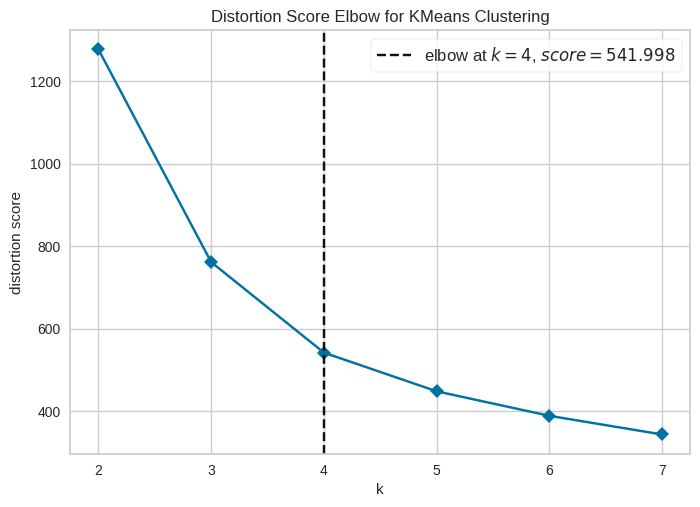

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    model,
    k=(2, 8),
    metric='distortion',
    timings=False
)

visualizer.fit(X_scaled)
visualizer.show()


###El método del codo permite identificar el número óptimo de clusters observando el punto donde la reducción de la inercia deja de ser significativa.

In [8]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

for k, score in zip(range(2,8), silhouette_scores):
    print(f"Clusters: {k} | Silhouette Score: {score:.3f}")


Clusters: 2 | Silhouette Score: 0.519
Clusters: 3 | Silhouette Score: 0.394
Clusters: 4 | Silhouette Score: 0.389
Clusters: 5 | Silhouette Score: 0.356
Clusters: 6 | Silhouette Score: 0.355
Clusters: 7 | Silhouette Score: 0.352


###El coeficiente de silueta mide qué tan bien separadas están las observaciones dentro de cada cluster. Valores cercanos a 1 indican una mejor segmentación

In [9]:
k_optimo = 3

kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

df.head()


,prob_muerte_cronica_total,prob_muerte_cronica_hombres,prob_muerte_cronica_mujeres,tasa_suicidios_total,tasa_suicidios_hombres,tasa_suicidios_mujeres,nivel_tasa_suicidio,cluster
0,29.8,31.8,27.7,4.7,7.6,1.5,baja,0
1,29.8,31.9,27.8,4.8,7.8,1.5,baja,0
2,31.7,34.1,29.4,5.1,8.6,1.4,baja,0
3,34.1,36.5,31.6,6.3,10.8,1.5,media,0
4,34.4,36.6,32.1,5.7,10.0,1.0,baja,0


In [10]:
cluster_summary = df.groupby('cluster')[features].mean()
cluster_summary


,prob_muerte_cronica_total,tasa_suicidios_total
cluster,,
0,24.357802,7.604176
1,27.067647,28.016176
2,15.081122,9.505357


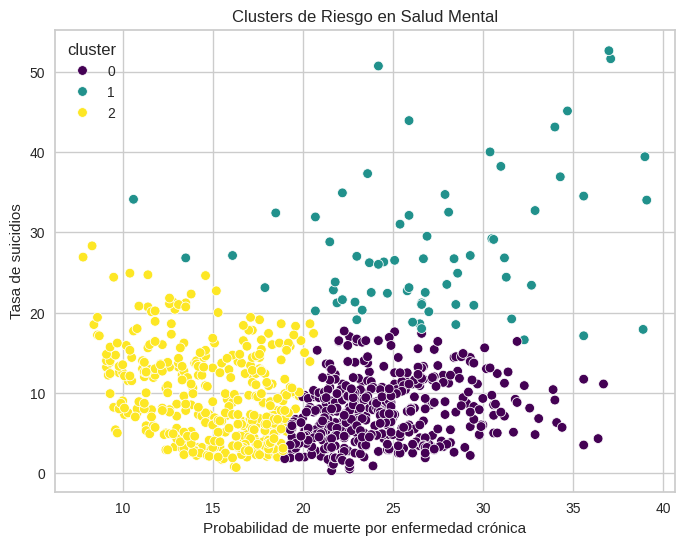

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='prob_muerte_cronica_total',
    y='tasa_suicidios_total',
    hue='cluster',
    palette='viridis',
    data=df
)

plt.title('Clusters de Riesgo en Salud Mental')
plt.xlabel('Probabilidad de muerte por enfermedad crónica')
plt.ylabel('Tasa de suicidios')
plt.show()


##🟨 Cluster de Riesgo Moderado (Amarillo)

<span style="color:#f1c40f;"><b>● Riesgo Moderado</b></span>

Este cluster agrupa a la población que presenta valores intermedios tanto en la tasa de suicidios como en la probabilidad de muerte por enfermedades crónicas. No se considera un grupo en situación crítica inmediata, pero sí muestra señales de vulnerabilidad que pueden evolucionar negativamente si no se aplican medidas preventivas.

Desde el punto de vista clínico, este grupo representa personas que podrían beneficiarse de programas de seguimiento psicológico, promoción de hábitos saludables y monitoreo continuo, con el objetivo de evitar que su condición escale a un nivel de mayor riesgo.

##🟦 Cluster de Bajo Riesgo (Turquesa)

<span style="color:#1abc9c;"><b>● Bajo Riesgo</b></span>

Este cluster corresponde a la población con los valores más bajos tanto en la tasa de suicidios como en la probabilidad de muerte por enfermedades crónicas. Representa un grupo con mejor estado general de salud, menor vulnerabilidad psicológica y menor probabilidad de eventos adversos relacionados con la salud mental.

Clínicamente, este grupo se asocia a estrategias de mantenimiento y promoción del bienestar, enfocadas en la prevención primaria y en la conservación de condiciones favorables de salud mental y física.

##🟪 Cluster de Alto Riesgo (Morado)

<span style="color:#8e44ad;"><b>● Alto Riesgo</b></span>

Este cluster agrupa a la población con los valores más elevados de tasa de suicidios y probabilidad de muerte por enfermedades crónicas. Representa el grupo de mayor vulnerabilidad, donde los factores de salud mental y condiciones físicas adversas se combinan de manera significativa.

Desde una perspectiva médica, este cluster requiere atención prioritaria, intervención temprana y estrategias de apoyo integral, ya que presenta una mayor probabilidad de eventos críticos y mortalidad asociada si no se implementan acciones correctivas oportunas.

In [12]:
import joblib

joblib.dump(kmeans, 'modelo_clustering_salud_mental.pkl')
joblib.dump(scaler, 'scaler_salud_mental.pkl')


['scaler_salud_mental.pkl']

###El modelo de clustering entrenado es utilizado como referencia para la interfaz web desarrollada en GitHub Pages. La interfaz permite introducir variables relacionadas con salud mental y asigna un grupo de atención basado en los patrones identificados por el modelo, con fines académicos y de simulación clínica.